In [2]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[0])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import scipy
import pickle
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import seaborn as sns
import sigpy as sp
import cupy as cp
import numpy as np
from sigpy.mri.app import TotalVariationRecon, L1WaveletRecon
from scipy.io import savemat

## My files
from plot_helpers import *
import raw_data_utils
from resp_signal_utils import *

### Data loading

Software version: VD/VE (!?)

Scan  0


100%|██████████| 15.9G/15.9G [00:13<00:00, 1.24GB/s]


Full number of partitions = 72
ksp_data.shape = (15, 58, 2002, 256)
Average value, slices vs samples per gate = 1.0259317605232354e-05
Average value, readouts vs spokes per gate = 6.189437499415362e-06
Average value, slices vs center sample per gate = 5.0106042181141675e-05


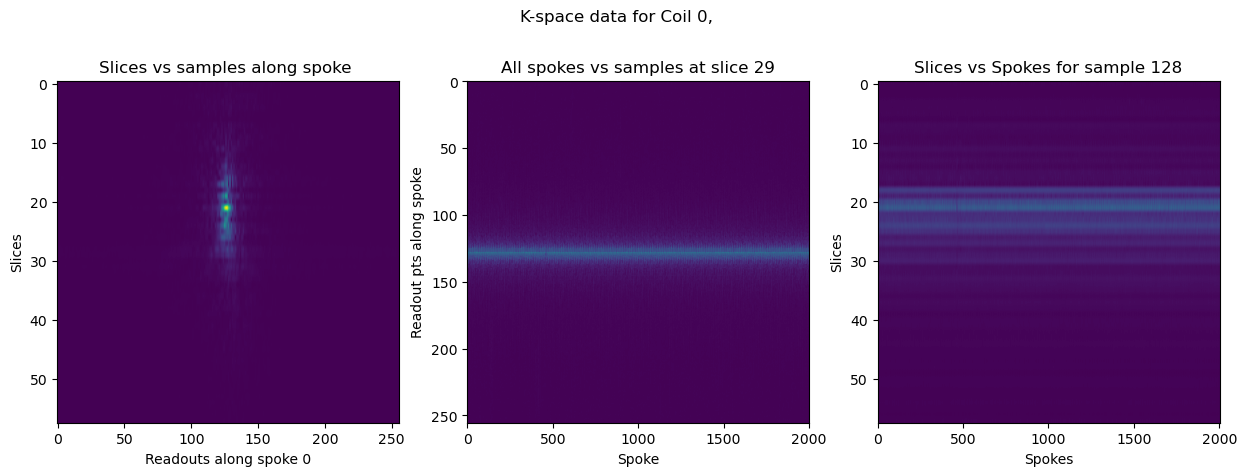

In [3]:
data_file_pt4 = '/home/lilianae/data/lilianae/NaF_Patient4/anon_meas_MID00062_FID67913_Tho_fl3d_star_vibe_991_nav_tj_2000sp_AllCoils_SOS_Qfatsat.dat'

multi_twix, mapped, ksp_data = raw_data_utils.get_kspace_data(data_file_pt4)
fig, axs = plot_ksp_data_multichannel(ksp_data=ksp_data, coil_idx=0)

### Get timestamp info from k-space, place all data into dictionary

In [4]:
chronological_data = raw_data_utils.get_chronological_data_points(multi_twix=multi_twix)

print("Example of list elements, chronological_data[0]: ")
print(f'    {chronological_data[0]}')

Example of list elements, chronological_data[0]: 
    {'timestamp': 21604187, 'partition': 0, 'line': 0, 'kspace_data': array([[ 2.11312380e-07-1.76991392e-06j,  2.16211429e-06+1.11277552e-06j,
        -1.17764570e-06+2.73883091e-06j, ...,
         2.82099872e-06+1.41734666e-06j, -1.06093758e-06+7.49802111e-07j,
         3.31278013e-07-1.94673043e-06j],
       [-3.14601140e-06+6.92724942e-07j,  4.60765976e-07+1.40123500e-06j,
        -4.16456112e-06+5.19221546e-07j, ...,
         3.10947126e-06-9.87205380e-07j, -7.25358440e-06-4.62914725e-06j,
        -3.07613767e-06+6.54290735e-06j],
       [ 1.14260989e-07-1.71533434e-07j, -1.31071873e-06-1.52711806e-07j,
        -1.11274907e-06-9.76653449e-07j, ...,
        -2.21854776e-06+2.80425481e-06j,  8.27932255e-07+1.98799364e-06j,
         2.56920625e-07+3.23159604e-06j],
       ...,
       [ 1.16303741e-06-8.67881761e-07j,  8.13924457e-07+9.44578680e-07j,
        -2.42794483e-06+2.06466523e-06j, ...,
         3.32200941e-06-3.64795568e-06j,

### Sort k-space data and sanity check

In [5]:
sorted_chronological_data = raw_data_utils.sort_data_chronological(chronological_data)
raw_data_utils.check_chronological_data(sorted_chronological_data)


First 10 data points (chronological order):
  Time 0: Par=0, Lin=0, Timestamp=21604187
  Time 1: Par=2, Lin=0, Timestamp=21604190
  Time 2: Par=3, Lin=0, Timestamp=21604192
  Time 3: Par=4, Lin=0, Timestamp=21604194
  Time 4: Par=7, Lin=0, Timestamp=21604197
  Time 5: Par=8, Lin=0, Timestamp=21604199
  Time 6: Par=9, Lin=0, Timestamp=21604202
  Time 7: Par=10, Lin=0, Timestamp=21604204
  Time 8: Par=11, Lin=0, Timestamp=21604206
  Time 9: Par=14, Lin=0, Timestamp=21604209


### Examine acquisition pattern for spoke 0

In [6]:
## Look at the sorted data for spoke/line 0
## The chronological ordering will tell us at what point each slice for spoke 0 was acquired
line_0_partitions = []
for i in range(len(chronological_data)):
    if chronological_data[i]['line'] == 0:
        line_0_partitions.append(chronological_data[i]['partition'])

print(f"Partition order for line 0: {line_0_partitions}")
print(f"Number of unique partitions: {len(set(line_0_partitions))}")

# Check when line 1 starts
for i in range(len(chronological_data)):
    if chronological_data[i]['line'] == 1:
        print(f"Line 1 starts at acquisition {i}, partition {chronological_data[i]['partition']}")
        break

Partition order for line 0: [0, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, 19, 21, 22, 24, 25, 26, 28, 29, 31, 32, 33, 36, 37, 38, 39, 41, 42, 43, 45, 47, 48, 49, 50, 53, 54, 55, 56, 1, 5, 12, 13, 18, 20, 23, 27, 30, 34, 35, 40, 44, 46, 51, 57, 6, 52]
Number of unique partitions: 58
Line 1 starts at acquisition 41, partition 2
